## Goal

I want to see if we can get good initialization for NMF-KL problem using [anchor-word based algorithm](https://arxiv.org/pdf/1212.4777.pdf). Ideally we want a fast algorithm where anchor-word algo + a few iterative updates can get us good enough solution (instead of hundreds or even thousands of iterative updates). 

## Details

* I use `sklearn.decomposition.NMF` with beta divergence to solve NMF-kl problem ($\text{min} \ D(X , WH) \ s.t. \ W, H \geq 0$) where $X$ is `n_sample` by `n_feature`). This package only supports multiplicative update at this point. 

* Since our anchor-word algorithm only solves for $H$, for each initialization method I fix $H$ at initialization $H_0$ then optimize $W$ to get $W_0$. 

* Loss is generalized KL divergence up to a constant. 

* Synthetic dataset used is generated [here](https://github.com/zihao12/pyJSMF-RAW/blob/master/experiments/sla_multinomial_sim_fit.py)

* Methods are: 
    - `anchor_oracle`: apply anchor-word algorithm but with true anchor words
    - `anchor0`: vanilla anchor-word algorithm
    - `anchor_ap`: anchor-word algorithm with [rectification](https://www.cs.cornell.edu/~bindel/papers/2015-nips.pdf)
    - `magic0`: use [magic](https://zihao12.github.io/pyJSMF-RAW/magic) to preprocess data in `find_anchor_word` step; then use original data to find $H$
    - `nndsvd`: [nndsvd](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
    - `random`: random intialization
    
* [script](https://github.com/zihao12/pyJSMF-RAW/blob/master/experiments/anchor_word_initialization_script.py) 


## Note:

* In order for `magic` + anchor-word algorithm to work well, we need a relatively large number of documents or document length. 

* Anchor-word algorithm is not very robust: if we find wrong anchor words, the initialization can be very bad. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt

import numpy as np
import pickle
from sklearn.decomposition import NMF, non_negative_factorization
from sklearn.decomposition._nmf import _beta_divergence

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from misc import *

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
np.random.seed(123)

In [2]:
%%capture
dataname = "sla"
k = 6
rate=3
datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
fittedfile=f"../experiments/anchor_word_initialization_sla_sim_rate{rate}.pkl"

with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X']
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']
n, p = X.shape

all_anchor_word = []
for i in range(k):
    ind = np.where(find_anchor_word_k(Ftrue, i) == True)[0].tolist()
    all_anchor_word += ind

with open(fittedfile, "rb") as f:
    out = pickle.load(f)

In [3]:
print(f"X shape: (n_sample, n_feature) =  {X.shape}")
print(f"mean document length {X.sum(axis = 1).mean().round()} words")

X shape: (n_sample, n_feature) =  (3207, 8766)
mean document length 255.0 words


## Compare loss at initialization 

In [4]:
# methodname = ['anchor_oracle', "anchor0", "anchor_ap", "magic0", "magic", "nndsvd", "random"]
methodname = ['anchor_oracle', "anchor0", "anchor_ap", "magic0", "nndsvd", "random"]
print(f"at convergence: {out['loss0']}")
for mn in methodname:
    print(f"{mn}: {out[f'loss_{mn}']}")

at convergence: 1737.0507589961198
anchor_oracle: 1745.768719954745
anchor0: 1888.9842495113949
anchor_ap: 1770.8495860183664
magic0: 1748.2128599551413
nndsvd: 1795.3995757752384
random: 1895.5816955540104


## Compare convergence

In [5]:
%%capture
def exper_init(X,W, H, iters):
    loss = []
    loss.append(_beta_divergence(X, W, H, 1, square_root=True))
    k = W.shape[1]
    for i in iters:
        W, H, _ = non_negative_factorization(X, n_components=k, init='custom', 
                                   random_state=0,W = W, H = H, 
                                  beta_loss='kullback-leibler', solver='mu',
                                  max_iter = i, tol=1e-30)
        loss.append(_beta_divergence(X, W, H, 1, square_root=True))
        
    return loss

iters = [1] * 40
loss = {}
for mn in methodname:
    loss[mn] = exper_init(X, out[f'W_{mn}'].copy(), out[f'H_{mn}'].copy(), iters)

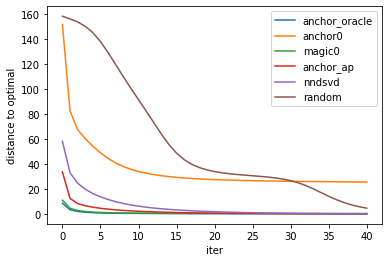

In [6]:
methodname_show = ['anchor_oracle', "anchor0", "magic0",  "anchor_ap", "nndsvd", "random"]
for mn in methodname_show:
    plt.plot(np.cumsum([0] + iters), loss[mn] - out['loss0'], label = mn)
plt.legend()
plt.xlabel("iter")
plt.ylabel("distance to optimal")
plt.show()

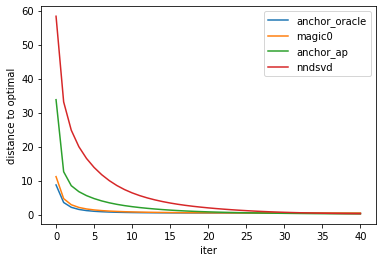

In [9]:
methodname_show = ['anchor_oracle', "magic0",  "anchor_ap", "nndsvd"]
for mn in methodname_show:
    plt.plot(np.cumsum([0] + iters), loss[mn] - out['loss0'], label = mn)
plt.legend()
plt.xlabel("iter")
plt.ylabel("distance to optimal")
plt.show()